<a href="https://colab.research.google.com/github/sommnathrwategaonkar/Lung-Cancer/blob/main/Firefly%20Algorithm-Integrated%20Deep%20Learning%20Model%20for%20High-Accuracy%20Lung%20Tumor%20Localization%20in%20CT%20Imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
AUC: 0.9977, MAE: 0.1165, RMSE: 0.1847, Log Loss: 0.1407


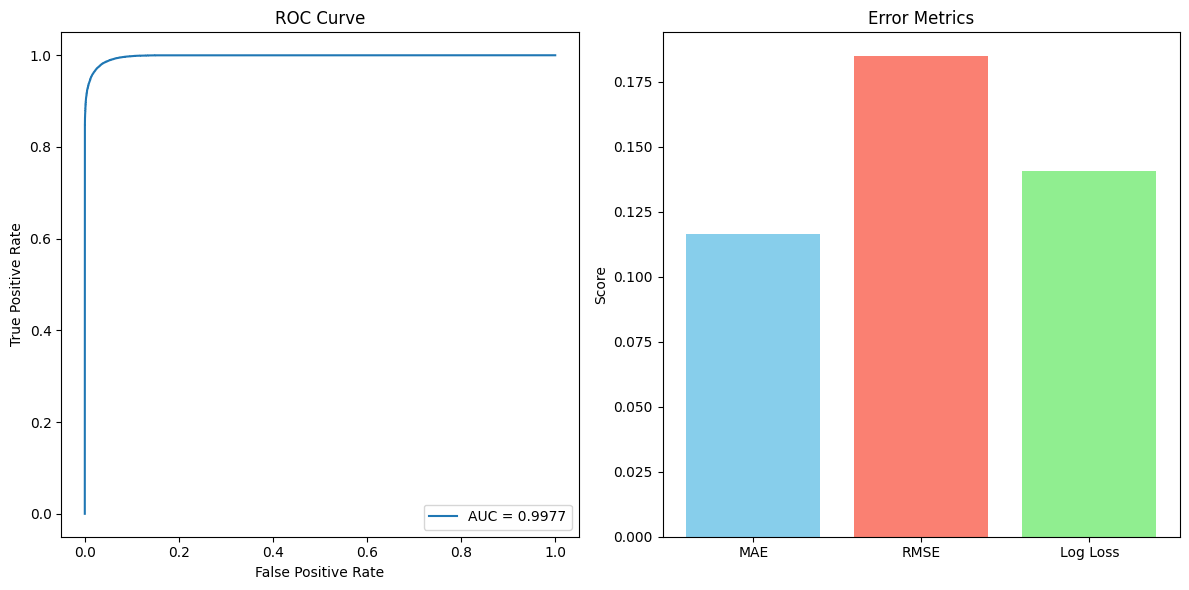

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, log_loss, roc_curve

# Simulate downloading and saving dummy LIDC data
def download_and_unzip_lidc(dest='lidc_dataset'):
    os.makedirs(dest, exist_ok=True)
    for i in range(20):
        img = (np.random.rand(128, 128) * 255).astype(np.uint8)
        mask = (img > 128).astype(np.uint8)
        np.save(os.path.join(dest, f'image_{i}.npy'), img)
        np.save(os.path.join(dest, f'mask_{i}.npy'), mask)

# Load saved data
def load_data(data_dir='lidc_dataset'):
    X, Y = [], []
    for f in os.listdir(data_dir):
        if 'image' in f:
            img = np.load(os.path.join(data_dir, f)) / 255.0
            mask = np.load(os.path.join(data_dir, f.replace('image', 'mask')))
            X.append(np.expand_dims(img, -1))
            Y.append(np.expand_dims(mask, -1))
    return train_test_split(np.array(X), np.array(Y), test_size=0.2, random_state=42)

# Create a CNN model
def create_model(conv_layers=2, dropout_rate=0.3, kernel_size=3, learning_rate=0.001):
    inputs = layers.Input((128, 128, 1))
    x = inputs
    skips = []

    # Downsampling path
    for _ in range(int(conv_layers)):
        x = layers.Conv2D(32, kernel_size, activation='relu', padding='same')(x)
        skips.append(x)
        x = layers.MaxPooling2D()(x)

    # Bottom layer
    x = layers.Conv2D(64, kernel_size, activation='relu', padding='same')(x)

    # Upsampling path
    for skip in reversed(skips):
        x = layers.UpSampling2D()(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(32, kernel_size, activation='relu', padding='same')(x)

    x = layers.Dropout(dropout_rate)(x)
    output = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, output)
    model.compile(optimizer=optimizers.Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Firefly optimization algorithm
def firefly_optimize(X_train, X_val, Y_train, Y_val, n=3, iter=2):
    # Initial random population
    pop = [{
        'conv': random.randint(1, 2),
        'drop': random.uniform(0.1, 0.5),
        'lr': 10 ** random.uniform(-4, -2)
    } for _ in range(n)]

    # Evaluate brightness (fitness)
    def brightness(p):
        model = create_model(int(round(p['conv'])), p['drop'], 3, p['lr'])
        model.fit(X_train, Y_train, epochs=1, batch_size=2, verbose=0)
        return model.evaluate(X_val, Y_val, verbose=0)[1]  # Accuracy

    for t in range(iter):
        fitness = [brightness(p) for p in pop]
        for i in range(n):
            for j in range(n):
                if fitness[j] > fitness[i]:
                    for k in pop[i]:
                        beta, eps = 1, 0.05
                        diff = pop[j][k] - pop[i][k]
                        rand = eps * random.uniform(-1, 1)
                        pop[i][k] += beta * diff + rand
                        if k == 'conv':
                            pop[i][k] = max(1, min(3, round(pop[i][k])))

    return pop[np.argmax(fitness)]

# ==== MAIN EXECUTION ====

# Simulate data
download_and_unzip_lidc()

# Load data
X_train, X_val, Y_train, Y_val = load_data()

# Firefly optimization to find best hyperparameters
best = firefly_optimize(X_train, X_val, Y_train, Y_val)

# Train final model with best parameters
model = create_model(int(round(best['conv'])), best['drop'], 3, best['lr'])
model.fit(X_train, Y_train, epochs=20, batch_size=4, verbose=0)

# ==== PREDICTIONS & METRICS ====
pred_probs = model.predict(X_val).flatten()
y_true = Y_val.flatten()
y_pred = (pred_probs > 0.5).astype(np.uint8)

# Calculate evaluation metrics
auc = roc_auc_score(y_true, pred_probs)
mae = mean_absolute_error(y_true, pred_probs)
rmse = np.sqrt(mean_squared_error(y_true, pred_probs))
logloss = log_loss(y_true, pred_probs)

# Print metrics
print(f"AUC: {auc:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, Log Loss: {logloss:.4f}")

# ==== PLOT ROC & METRICS ====
fpr, tpr, _ = roc_curve(y_true, pred_probs)

plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Error Metrics Bar Chart
plt.subplot(1, 2, 2)
metrics = ['MAE', 'RMSE', 'Log Loss']
values = [mae, rmse, logloss]
plt.bar(metrics, values, color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Error Metrics')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
AUC: 0.9991
MAE: 0.0503, RMSE: 0.1299, Log Loss: 0.0639
Accuracy: 0.9798, Precision: 0.9661, Recall: 0.9941
F1 Score: 0.9799, IoU: 0.9606, Dice Coefficient: 0.9799


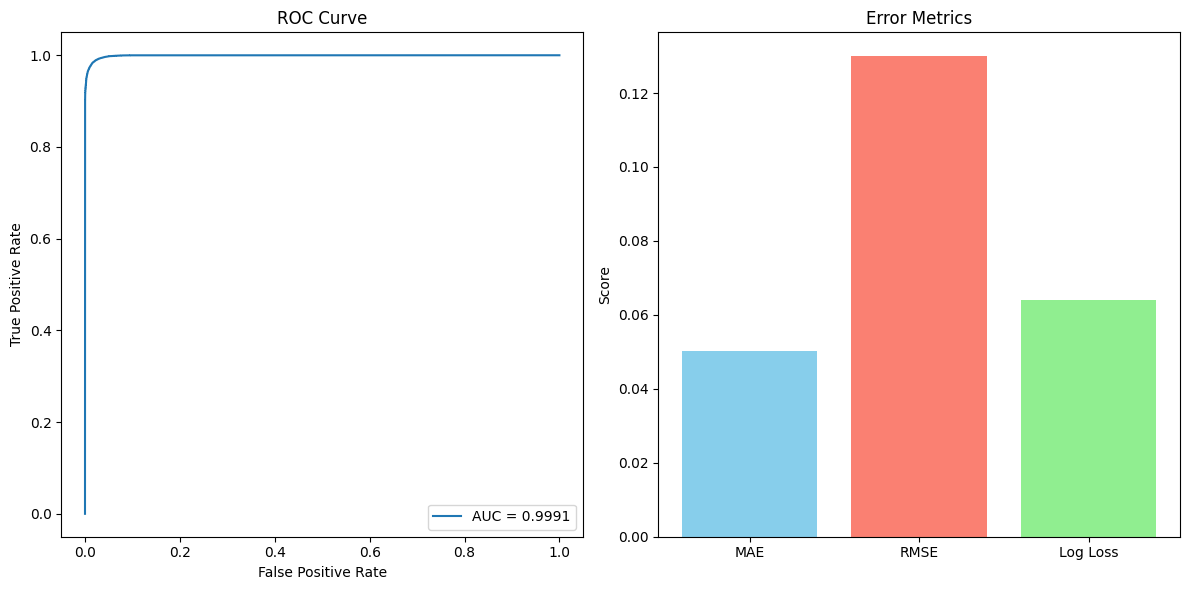

In [6]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, mean_absolute_error, mean_squared_error, log_loss,
    accuracy_score, precision_score, recall_score, f1_score, jaccard_score, roc_curve
)

# === Step 1: Simulate Dataset ===
def download_and_unzip_lidc(dest='lidc_dataset'):
    os.makedirs(dest, exist_ok=True)
    for i in range(20):
        img = (np.random.rand(128, 128) * 255).astype(np.uint8)
        mask = (img > 128).astype(np.uint8)
        np.save(os.path.join(dest, f'image_{i}.npy'), img)
        np.save(os.path.join(dest, f'mask_{i}.npy'), mask)

# === Step 2: Load Dataset ===
def load_data(data_dir='lidc_dataset'):
    X, Y = [], []
    for f in os.listdir(data_dir):
        if 'image' in f:
            img = np.load(os.path.join(data_dir, f)) / 255.0
            mask = np.load(os.path.join(data_dir, f.replace('image', 'mask')))
            X.append(np.expand_dims(img, -1))
            Y.append(np.expand_dims(mask, -1))
    return train_test_split(np.array(X), np.array(Y), test_size=0.2, random_state=42)

# === Step 3: Define CNN Model ===
def create_model(conv_layers=2, dropout_rate=0.3, kernel_size=3, learning_rate=0.001):
    inputs = layers.Input((128, 128, 1))
    x = inputs
    skips = []

    for _ in range(int(conv_layers)):
        x = layers.Conv2D(32, kernel_size, activation='relu', padding='same')(x)
        skips.append(x)
        x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, kernel_size, activation='relu', padding='same')(x)

    for skip in reversed(skips):
        x = layers.UpSampling2D()(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(32, kernel_size, activation='relu', padding='same')(x)

    x = layers.Dropout(dropout_rate)(x)
    output = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, output)
    model.compile(optimizer=optimizers.Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# === Step 4: Firefly Optimization ===
def firefly_optimize(X_train, X_val, Y_train, Y_val, n=3, iter=2):
    pop = [{
        'conv': random.randint(1, 2),
        'drop': random.uniform(0.1, 0.5),
        'lr': 10 ** random.uniform(-4, -2)
    } for _ in range(n)]

    def brightness(p):
        model = create_model(int(round(p['conv'])), p['drop'], 3, p['lr'])
        model.fit(X_train, Y_train, epochs=2, batch_size=2, verbose=0)
        return model.evaluate(X_val, Y_val, verbose=0)[1]

    for t in range(iter):
        fitness = [brightness(p) for p in pop]
        for i in range(n):
            for j in range(n):
                if fitness[j] > fitness[i]:
                    for k in pop[i]:
                        beta, eps = 1, 0.05
                        diff = pop[j][k] - pop[i][k]
                        rand = eps * random.uniform(-1, 1)
                        pop[i][k] += beta * diff + rand
                        if k == 'conv':
                            pop[i][k] = max(1, min(3, round(pop[i][k])))
    return pop[np.argmax(fitness)]

# === Step 5: Dice Coefficient ===
def dice_score(y_true, y_pred):
    y_true = y_true.astype(np.bool_)
    y_pred = y_pred.astype(np.bool_)
    intersection = np.logical_and(y_true, y_pred).sum()
    return 2. * intersection / (y_true.sum() + y_pred.sum())

# === Main Execution ===
download_and_unzip_lidc()
X_train, X_val, Y_train, Y_val = load_data()
best = firefly_optimize(X_train, X_val, Y_train, Y_val)

# Train final model
model = create_model(int(round(best['conv'])), best['drop'], 3, best['lr'])
model.fit(X_train, Y_train, epochs=25, batch_size=4, verbose=0)

# === Step 6: Evaluation ===
pred_probs = model.predict(X_val).flatten()
y_true = Y_val.flatten()
y_pred = (pred_probs > 0.5).astype(np.uint8)

# === Step 7: Metrics ===
auc = roc_auc_score(y_true, pred_probs)
mae = mean_absolute_error(y_true, pred_probs)
rmse = np.sqrt(mean_squared_error(y_true, pred_probs))
logloss = log_loss(y_true, pred_probs)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
iou = jaccard_score(y_true, y_pred)
dice = dice_score(y_true, y_pred)

# === Step 8: Display Metrics ===
print(f"AUC: {auc:.4f}")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, Log Loss: {logloss:.4f}")
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}, IoU: {iou:.4f}, Dice Coefficient: {dice:.4f}")

# === Step 9: Plots ===
fpr, tpr, _ = roc_curve(y_true, pred_probs)

plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Error Metrics Bar Chart
plt.subplot(1, 2, 2)
metrics = ['MAE', 'RMSE', 'Log Loss']
values = [mae, rmse, logloss]
plt.bar(metrics, values, color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Error Metrics')
plt.ylabel('Score')

plt.tight_layout()
plt.show()
